In [1]:
import result_processing
import os
import argparse
from reddit.data_cleaning.reddit_posts import load_term_counts
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression, LinearRegression
from scipy.special import logit
from scipy.stats import chi2, ttest_1samp
from result_processing.helpers import convert_str_columns_to_float, assign_split, filter_imbalanced_terms
from importlib import reload
from sklearn.metrics import mean_squared_error as mse

In [2]:
def fit_treatment(features, labels, verbose=False, coeff_offset=1):
    model = LogisticRegression(solver='liblinear')
    model.fit(features, labels)
    coeffs = np.array(model.coef_).flatten()[coeff_offset:]
    if verbose:
        print("Model accuracy:", model.score(features, labels))
        print("Mean and std. of the word coeffs:", coeffs.mean(), coeffs.std())     
    return coeffs

def truncate(df, truncate_level=0.1):
    df = df[(df.treatment_probability >= truncate_level) & (df.treatment_probability <= 1.0-truncate_level)]
    return df

def fit_outcome(features, labels, verbose=False, coeff_offset=1):
    model = LinearRegression()
    model.fit(features, labels)
    coeffs = np.array(model.coef_).flatten()[coeff_offset:]
    if verbose:
        print("Model MSE:", mse(labels,model.predict(features)))
        print("Mean and std. of the word coeffs:", coeffs.mean(), coeffs.std())
    return coeffs 

In [3]:
log_dir = '../logdir/modesimple/beta01.0.beta110.0.gamma1.0'

In [4]:
predictions_file = os.path.join(log_dir, 'predict', 'test_results_all.tsv')
predict_df = pd.read_csv(predictions_file, delimiter='\t')
predict_df = convert_str_columns_to_float(predict_df)
predict_df = predict_df.rename(columns={'index':'post_index'})
predict_df = truncate(predict_df)
print(predict_df.shape)

(93916, 7)


In [5]:
term_counts, author_term_counts, vocab = load_term_counts()
print(term_counts.shape)

(422206, 529)


In [6]:
imbalanced_terms = filter_imbalanced_terms(predict_df, term_counts,imbalance=0.1)
term_counts = term_counts[:,imbalanced_terms]
term_counts.shape

(422206, 119)

In [51]:
n_bootstraps = 10
n_w = term_counts.shape[1]
adjusted = np.zeros((n_bootstraps, n_w))
permuted = np.zeros((n_bootstraps, n_w))
unadjusted = np.zeros((n_bootstraps, n_w))

for i in range(n_bootstraps):
    sample = assign_split(predict_df,num_splits=2)
    sample = sample[sample.split==1]
    indices = sample.post_index.values
    labels = sample.treatment.values
    words = term_counts[indices, :].toarray()
    propensity_score = logit(sample.treatment_probability.values)
    all_features = np.column_stack((propensity_score, words))
    
    adjusted[i,:] = fit_treatment(all_features, labels, verbose=True)
    unadjusted[i,:] = fit_treatment(words, labels, coeff_offset=0, verbose=True)
    np.random.shuffle(words)
    permuted_features = np.column_stack((propensity_score, words))
    permuted[i,:] = fit_treatment(permuted_features, labels)

Model accuracy: 0.6995408944057133
Mean and std. of the word coeffs: 0.014636964965330776 0.1787484819598313
Model accuracy: 0.5842118687298079
Mean and std. of the word coeffs: -0.04361795603189822 0.30104023302986554
Model accuracy: 0.6990977187606401
Mean and std. of the word coeffs: 0.010864669181085081 0.1690052283496078
Model accuracy: 0.5815457950289411
Mean and std. of the word coeffs: -0.043216267456407616 0.29639779161934204
Model accuracy: 0.6968472109943411
Mean and std. of the word coeffs: 0.014937959245977598 0.19088597155457082
Model accuracy: 0.5836063481257712
Mean and std. of the word coeffs: -0.04322841833286749 0.3109966014721763
Model accuracy: 0.7000980141481292
Mean and std. of the word coeffs: 0.00850213760582418 0.174732192234564
Model accuracy: 0.5835037927213841
Mean and std. of the word coeffs: -0.04480548729197767 0.3087422986468522
Model accuracy: 0.7000170010200613
Mean and std. of the word coeffs: 0.020032151570105128 0.19107010356078805
Model accuracy: 

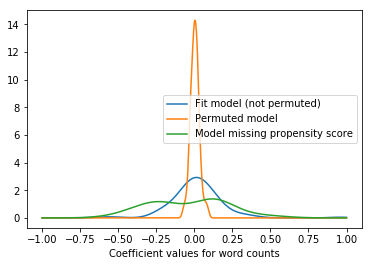

In [42]:
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
density = gaussian_kde(adjusted.mean(axis=0))
permutation_density = gaussian_kde(permuted.mean(axis=0))
missing_z_density = gaussian_kde(unadjusted.mean(axis=0))
xs = np.linspace(-1.,1.,1000)
# density.covariance_factor = lambda : .55
# density._compute_covariance()
plt.plot(xs,density(xs), label='Fit model (not permuted)')
plt.plot(xs, permutation_density(xs), label='Permuted model')
plt.plot(xs, missing_z_density(xs), label='Model missing propensity score')
plt.xlabel('Coefficient values for word counts')
plt.legend()
plt.show()

In [140]:
blacklist = ['theorem', 'theoretical', 'theoretically', 'theory']
from lda_baseline.peerread_fit_topics import load_term_counts as ltc
peerread_log_dir = '../logdir/peerread/modesimple/beta00.25.beta11.0.gamma0.0/split0'
predictions_file = os.path.join(peerread_log_dir, 'predict', 'test_results.tsv')
predict_df = pd.read_csv(predictions_file, delimiter='\t')
# predict_df = predict_df[predict_df.in_test==1.0]
term_counts,vocab = ltc(None)
term_counts = term_counts[:,~np.isin(vocab,blacklist)]
term_counts = term_counts.toarray()
print(term_counts.shape)

# random_indices = np.random.choice(np.arange(4684), 4000)
# term_counts = term_counts[:,random_indices]

(11778, 4684)


In [141]:
n_bootstraps = 1
n_w = term_counts.shape[1]
adjusted = np.zeros((n_bootstraps, n_w))
permuted = np.zeros((n_bootstraps, n_w))
unadjusted = np.zeros((n_bootstraps, n_w))
for i in range(n_bootstraps):
    sample = assign_split(predict_df,num_splits=2)
    sample = sample[sample.split==0]
    indices = sample.index.values
    labels = sample.treatment.values
    words = term_counts[indices, :]
    propensity_score = logit(sample.treatment_probability.values)
    all_features = np.column_stack((propensity_score, words))
    unadjusted[i,:] = fit_treatment(words, labels, coeff_offset=0, verbose=True)
    adjusted[i,:] = fit_treatment(all_features, labels)
    np.random.shuffle(words)
    permuted_features = np.column_stack((propensity_score, words))
    permuted[i,:] = fit_treatment(permuted_features, labels)

Model accuracy: 0.9960447119518486
Mean and std. of the word coeffs: -0.012592992339901141 0.3258735530622863


In [142]:
coeffs = unadjusted[0,:]
top = np.argsort(abs(coeffs))[-10:]
vocab[top]

array(['involves', 'bounded', 'fundamental', 'feedforward', 'achieved',
       'multiplication', 'guarantee', 'chosen', 'computable', 'prove'],
      dtype='<U17')

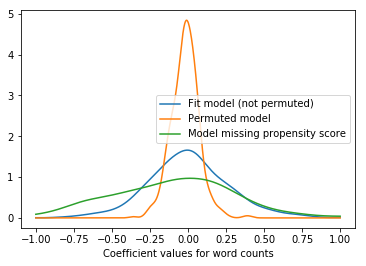

In [117]:
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
density = gaussian_kde(adjusted.mean(axis=0))
permutation_density = gaussian_kde(permuted.mean(axis=0))
missing_z_density = gaussian_kde(unadjusted.mean(axis=0))
xs = np.linspace(-1.,1.,1000)
plt.plot(xs,density(xs), label='Fit model (not permuted)')
plt.plot(xs, permutation_density(xs), label='Permuted model')
plt.plot(xs, missing_z_density(xs), label='Model missing propensity score')
plt.xlabel('Coefficient values for word counts')
plt.legend()
plt.show()

In [34]:
exog_sim_low = '../logdir/prop_sim/modesimple/beta01.0.beta110.0.exog0.0'
exog_sim_high = '../logdir/prop_sim/modesimple/beta01.0.beta110.0.exog0.8'
predictions_file = os.path.join(exog_sim_low, 'predict', 'test_results_keto.tsv')
predict_df = pd.read_csv(predictions_file, delimiter='\t')
predict_df = predict_df.rename(columns={'index':'post_index'})
term_counts,_,_ = load_term_counts()
term_counts = term_counts.toarray()

In [35]:
n_bootstraps = 10
n_w = term_counts.shape[1]
adjusted = np.zeros((n_bootstraps, n_w))
permuted = np.zeros((n_bootstraps, n_w))
unadjusted = np.zeros((n_bootstraps, n_w))
for i in range(n_bootstraps):
    sample = assign_split(predict_df,num_splits=2)
    sample = sample[sample.split==0]
    indices = sample.post_index.values
    labels = sample.treatment.values
    words = term_counts[indices, :]
    propensity_score = logit(sample.treatment_probability.values)
    all_features = np.column_stack((propensity_score, words))
    unadjusted[i,:] = fit_treatment(words, labels, coeff_offset=0,verbose=True)
    adjusted[i,:] = fit_treatment(all_features, labels)
    np.random.shuffle(words)
    permuted_features = np.column_stack((propensity_score, words))
    permuted[i,:] = fit_treatment(permuted_features, labels)

Model accuracy: 0.6096851788216013
Mean and std. of the word coeffs: -0.016464023555452536 0.16569509106403862
Model accuracy: 0.6108376991056782
Mean and std. of the word coeffs: -0.015326543983318373 0.1627639900466207
Model accuracy: 0.6095973119126371
Mean and std. of the word coeffs: -0.012424147449095903 0.15932028828285638
Model accuracy: 0.6087036598521325
Mean and std. of the word coeffs: -0.01104095630703616 0.16641578254477737
Model accuracy: 0.6058602869809292
Mean and std. of the word coeffs: -0.012674520240197615 0.164004180674775
Model accuracy: 0.6120621334601363
Mean and std. of the word coeffs: -0.01667251411468293 0.16358118039087283
Model accuracy: 0.6105448895209502
Mean and std. of the word coeffs: -0.013781926949811967 0.15966880277178389
Model accuracy: 0.6085096268124555
Mean and std. of the word coeffs: -0.0162789379375924 0.17024585723303765
Model accuracy: 0.6100081947712073
Mean and std. of the word coeffs: -0.01488983582065513 0.16324582380766917
Model acc

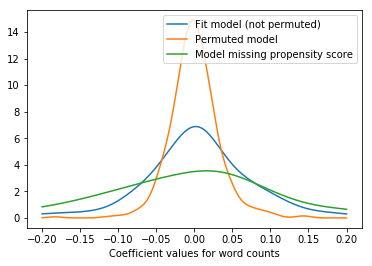

In [36]:
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
density = gaussian_kde(adjusted.mean(axis=0))
permutation_density = gaussian_kde(permuted.mean(axis=0))
missing_z_density = gaussian_kde(unadjusted.mean(axis=0))
xs = np.linspace(-0.2,0.2,1000)
plt.plot(xs,density(xs), label='Fit model (not permuted)')
plt.plot(xs, permutation_density(xs), label='Permuted model')
plt.plot(xs, missing_z_density(xs), label='Model missing propensity score')
plt.xlabel('Coefficient values for word counts')
plt.legend()
plt.show()